In [64]:
import copy
import time
import itertools
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats import skew
from abm.initialization import generate_random_entities  #, generate_new_entities
from abm.essentials import merge_dict
from abm.create_network_connections import create_network_connections
# from abm.logs import LogMessage
from abm.calibration import get_calibration_variables
from abm.markov_model import MarkovModel
from abm.clear_firm_default import clear_firm_default
from abm.clear_interbank_market import clear_interbank_market

In [7]:
from abm.abm_simulation import abm_sim
import numpy as np

In [81]:
covered = np.linspace(0,0.7,8)
uncovered = np.linspace(0,0.7,8)
covered = np.around(covered, 1)
uncovered = np.around(uncovered, 1)

In [82]:
uncovered

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [39]:
param = []
for c in covered:
    for u in uncovered:
        param.append([c,u])

In [5]:
import multiprocessing

In [6]:
with multiprocessing.Pool() as pool:
    results = pool.map(abm_sim, param)

/Users/patricklucescu/Dropbox/Research/Bridge/A4/Repository/bridge-a4-systemic-risk/abm/clear_interbank_market.py:39: RuntimeWarning: divide by zero encountered in divide
  Pi = np.matmul(np.diag(1 / Lbar), liabilities)
/Users/patricklucescu/Dropbox/Research/Bridge/A4/Repository/bridge-a4-systemic-risk/abm/clear_interbank_market.py:39: RuntimeWarning: invalid value encountered in matmul
  Pi = np.matmul(np.diag(1 / Lbar), liabilities)


Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defaulting firms
2028
Period 0: Get defaulting banks
1
Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defaulting firms
1912
Period 0: Get defaulting banks
1
Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defaulting firms
1960
Period 0: Get defaulting banks
0
Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defaulting firms
2006
Period 0: Get defaulting banks
0
Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defaulting firms
1974
Period 0: Get defaulting banks
0
Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defaulting firms
1915
Period 0: Get defaulting banks
0
Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defau

In [15]:
import pickle
import matplotlib.pyplot as plt

In [9]:
with open('saved_data.pkl', 'wb') as f:
    pickle.dump((param, results), f)

# Load data and analyze

In [3]:
with open('saved_data.pkl', 'rb') as f:
    (param, results) = pickle.load(f)

In [19]:
simulation_data, empirical_data = results[0][2:]

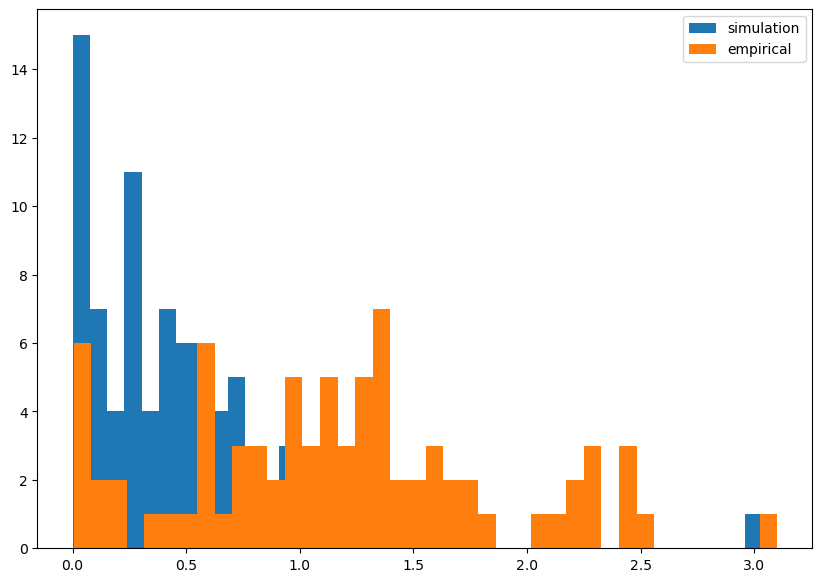

In [76]:
plt.figure(figsize=(10,7))
plt.hist(simulation_data, bins=40, label='simulation')
plt.hist(empirical_data, bins=40, label='empirical')
plt.legend()
plt.savefig('plots/lr_ratio.jpg',bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

In [49]:
# create the change in equity
equity_change = []
for res in results:
    post_period_equity, prior_period_equity = res[:2]
    equity_change.append([100 * (post_period_equity[i] - prior_period_equity[i]) / prior_period_equity[i] 
                          for i in prior_period_equity.keys()])

In [54]:
len(equity_change)

64

In [69]:
df = pd.DataFrame({'param': param,
                   'equity_change': equity_change})
df['covered'] = df.param.apply(lambda x: x[0])
df['uncovered'] = df.param.apply(lambda x: x[1])
df = df[['covered', 'uncovered', 'equity_change']]
df['mean'] = df.equity_change.apply(lambda x: np.mean(x))
df['median'] = df.equity_change.apply(lambda x: np.median(x))
df['std'] = df.equity_change.apply(lambda x: np.std(x))
df['skew'] = df.equity_change.apply(lambda x: skew(x))
df['25%'] = df.equity_change.apply(lambda x: np.quantile(x, 0.25))
df['10%'] = df.equity_change.apply(lambda x: np.quantile(x, 0.1))
df['5%'] = df.equity_change.apply(lambda x: np.quantile(x, 0.05))
df['1%'] = df.equity_change.apply(lambda x: np.quantile(x, 0.01))

In [87]:
import matplotlib.pyplot as plt

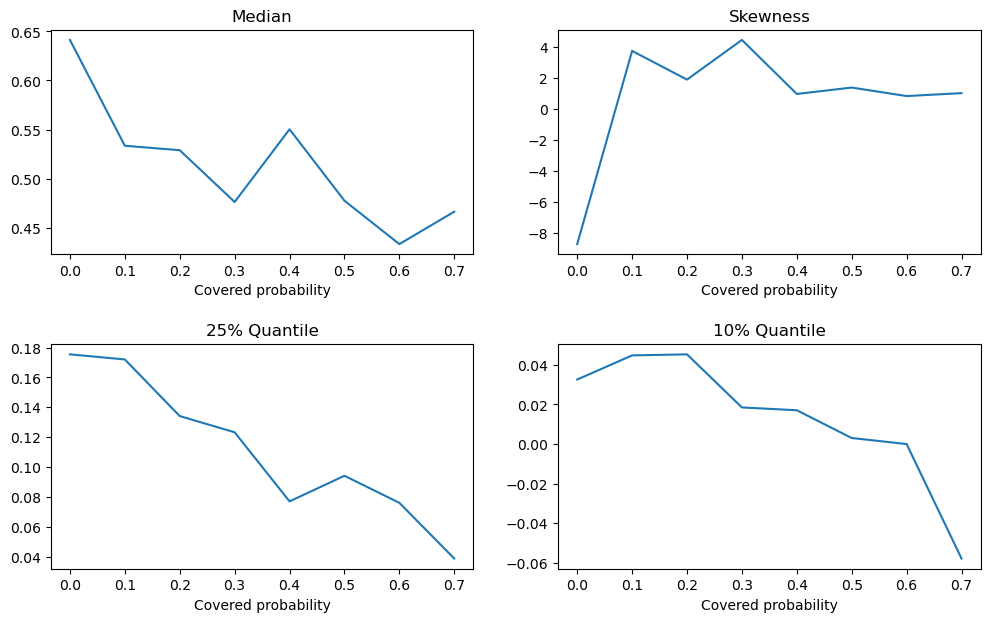

In [121]:
# uncovered set to 0 and very covered
df_zero_uncov = df[df.uncovered == 0]

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

axs[0, 0].plot(covered, df_zero_uncov['median'])
axs[0, 0].set_title('Median')
axs[0, 0].set_xlabel('Covered probability')


axs[0, 1].plot(covered, df_zero_uncov['skew'])
axs[0, 1].set_title('Skewness')
axs[0, 1].set_xlabel('Covered probability')

axs[1, 0].plot(covered, df_zero_uncov['25%'])
axs[1, 0].set_title('25% Quantile')
axs[1, 0].set_xlabel('Covered probability')

axs[1, 1].plot(covered, df_zero_uncov['10%'])
axs[1, 1].set_title('10% Quantile')
axs[1, 1].set_xlabel('Covered probability')

plt.subplots_adjust(hspace=0.4) 
plt.savefig('plots/uncov_0.jpg',bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

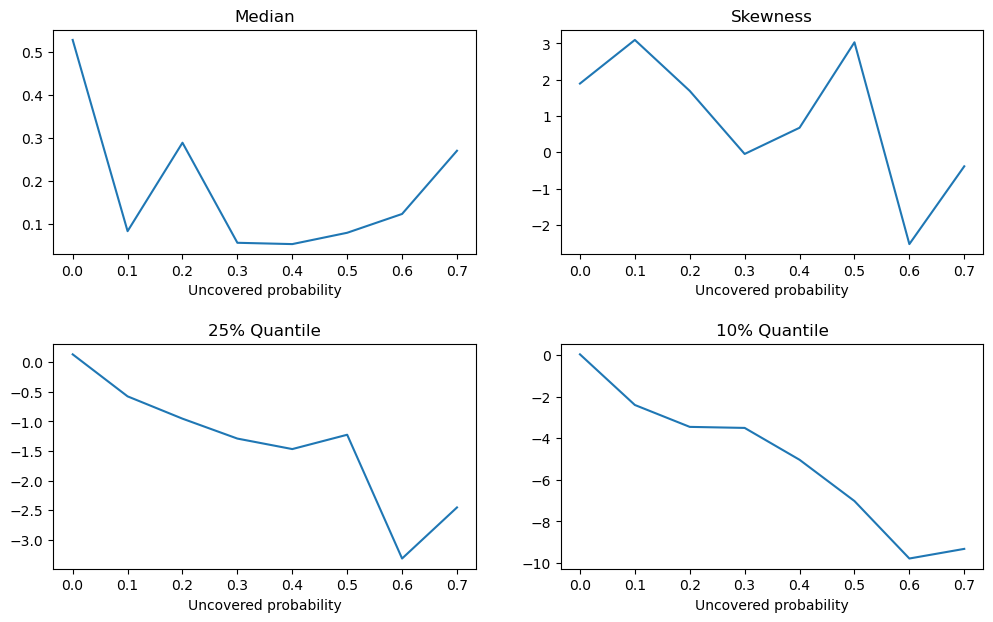

In [120]:
# uncovered set to 0 and very covered
df_zero_uncov = df[df.covered == 0.2]

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

axs[0, 0].plot(covered, df_zero_uncov['median'])
axs[0, 0].set_title('Median')
axs[0, 0].set_xlabel('Uncovered probability')


axs[0, 1].plot(covered, df_zero_uncov['skew'])
axs[0, 1].set_title('Skewness')
axs[0, 1].set_xlabel('Uncovered probability')

axs[1, 0].plot(covered, df_zero_uncov['25%'])
axs[1, 0].set_title('25% Quantile')
axs[1, 0].set_xlabel('Uncovered probability')

axs[1, 1].plot(covered, df_zero_uncov['10%'])
axs[1, 1].set_title('10% Quantile')
axs[1, 1].set_xlabel('Uncovered probability')

plt.subplots_adjust(hspace=0.4) 
plt.savefig('plots/cov_0.2.jpg',bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()